In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                                std=[0.20, 0.20, 0.20])
                       ])
                       )
data_test = dset.SVHN('./data/', split='test',
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])
                      ]))

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [9]:
train_sampler

In [10]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)


# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [11]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [17]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,
                scheduler = StepLR(optimizer, step_size = 1, gamma = 1.0)):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(loader):
            prediction = model(x)
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

        val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

C:\Users\mcinf\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Average loss: 1.420420, Train accuracy: 0.638296, Val accuracy: 0.646441
Average loss: 1.385145, Train accuracy: 0.656042, Val accuracy: 0.674630
Average loss: 1.364313, Train accuracy: 0.664693, Val accuracy: 0.679749


In [13]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100 instead of 1
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.164926, Train accuracy: 0.210934, Val accuracy: 0.240734
Average loss: 2.001930, Train accuracy: 0.275450, Val accuracy: 0.293905
Average loss: 1.831048, Train accuracy: 0.352404, Val accuracy: 0.394717
Average loss: 1.717133, Train accuracy: 0.416135, Val accuracy: 0.422633
Average loss: 1.678094, Train accuracy: 0.434444, Val accuracy: 0.430892


In [14]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.042413, Train accuracy: 0.316503, Val accuracy: 0.446864
Average loss: 1.727278, Train accuracy: 0.488687, Val accuracy: 0.541738
Average loss: 1.600103, Train accuracy: 0.554363, Val accuracy: 0.591359
Average loss: 1.520235, Train accuracy: 0.591629, Val accuracy: 0.600915
Average loss: 1.460474, Train accuracy: 0.620124, Val accuracy: 0.655587


In [18]:
# Learing rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size = 2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 2.071896, Train accuracy: 0.299765, Val accuracy: 0.407617
Average loss: 1.807323, Train accuracy: 0.452479, Val accuracy: 0.489659
Average loss: 1.713124, Train accuracy: 0.497321, Val accuracy: 0.522490
Average loss: 1.657563, Train accuracy: 0.525936, Val accuracy: 0.551976
Average loss: 1.626050, Train accuracy: 0.542760, Val accuracy: 0.565627


In [23]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset

    Returns:
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=SubsetSampler(indices))
    with torch.no_grad():
        predictions = []
        ground_truth = []
        for sample, label in loader:
            prediction = model(sample)
            label_predict = torch.argmax(prediction, 1)
            predictions = np.concatenate((predictions, label_predict))
            ground_truth = np.concatenate((ground_truth, label))
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!


    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

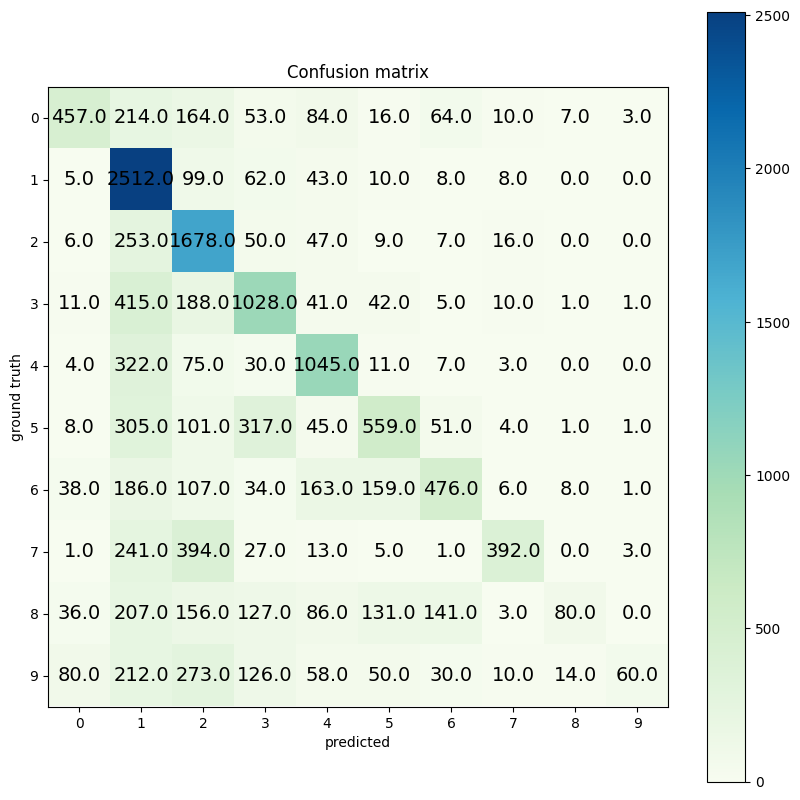

In [24]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix

    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth

    """
    # Adapted from
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.xlabel("predicted")
    plt.ylabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')

def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples

    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """

    confusion_matrix = np.zeros((10,10))
    for index, label in enumerate(ground_truth):
        confusion_matrix[int(label)][int(predictions[index])] += 1
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

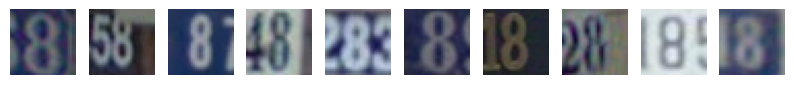

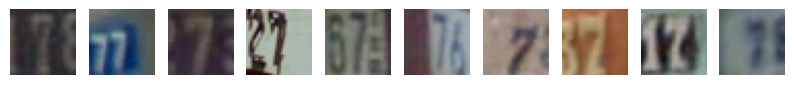

In [25]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset

    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class

    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices_for_image = []
    for index, label in enumerate(predictions):
        if (label == predicted_class) and (groud_truth[index] == gt_class):
            indices_for_image.append(val_indices[index])

    visualize_images(indices_for_image, data)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

In [29]:
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=False)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.287316, Train accuracy: 0.593574, Val accuracy: 0.699611
Average loss: 0.921667, Train accuracy: 0.721087, Val accuracy: 0.730121
Average loss: 0.826430, Train accuracy: 0.750537, Val accuracy: 0.728483


In [33]:
nn_model_2 = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = torch.optim.Adam(nn_model_2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)
scheduler = StepLR(optimizer, step_size = 10, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model_2, train_loader, val_loader, loss, optimizer, 20, scheduler)

Average loss: 1.469254, Train accuracy: 0.542845, Val accuracy: 0.683776
Average loss: 1.008041, Train accuracy: 0.697710, Val accuracy: 0.736400
Average loss: 0.869095, Train accuracy: 0.739958, Val accuracy: 0.758037
Average loss: 0.787278, Train accuracy: 0.766201, Val accuracy: 0.777831
Average loss: 0.741961, Train accuracy: 0.778521, Val accuracy: 0.782472
Average loss: 0.707034, Train accuracy: 0.787854, Val accuracy: 0.783769
Average loss: 0.690829, Train accuracy: 0.792120, Val accuracy: 0.802880
Average loss: 0.661235, Train accuracy: 0.803228, Val accuracy: 0.795577
Average loss: 0.657703, Train accuracy: 0.804508, Val accuracy: 0.796055
Average loss: 0.581837, Train accuracy: 0.829608, Val accuracy: 0.827793
Average loss: 0.569954, Train accuracy: 0.829710, Val accuracy: 0.825473
Average loss: 0.559612, Train accuracy: 0.834932, Val accuracy: 0.831343
Average loss: 0.554662, Train accuracy: 0.834317, Val accuracy: 0.823766
Average loss: 0.544757, Train accuracy: 0.836382, V

In [34]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model_2, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)


Test accuracy: 0.8228
